In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from flux_utils import flux_conversion
from astropy import units as u
from astropy import constants as const
import numpy as np
from data import aeff_ehe_gfu, aeff_ehe, aeff_hese
from plots import fontsize, fig_width
from blackbody import wiens_law

        #date          flux  tbb_kev          r_cm instrument     UL      MJD
0  2019-05-30  1.540000e-12    0.066  2.000000e+11        XMM  False  58633.0
1  2019-10-23  4.000000e-14      NaN           NaN        XMM   True  58779.0
         #MJD       #date        MJD     UL  counts  counts_err          flux  \
0   58620.209         NaN  58620.209  False  0.0622      0.0061  4.270000e-12   
1   58624.083         NaN  58624.083  False  0.0185      0.0098  1.270000e-12   
2   58627.207         NaN  58627.207  False  0.0287      0.0067  1.970000e-12   
3   58630.324         NaN  58630.324  False  0.0502      0.0089  3.450000e-12   
4   58633.586         NaN  58633.586  False  0.0349      0.0050  2.400000e-12   
5   58636.198         NaN  58636.198  False  0.0190      0.0038  1.300000e-12   
6   58639.852         NaN  58639.852  False  0.0027      0.0015  1.840000e-13   
7   58642.438         NaN  58642.438  False  0.0113      0.0033  7.760000e-13   
8   58645.426         NaN  58645.426 

In [2]:
# Simple approximation scaling from TXS 0506+056

# x = [200 * 10**12, 10*10.**15]
x = [100 * 10**12, 10*10.**15]


e_integral = np.log(x[1]/x[0])

ul_txs_6_month_flux = 5. * 10 **-11. * u.erg / (u.cm**2 * u.s)
ul_txs_6_month = ul_txs_6_month_flux /(flux_conversion/u.cm**2)

fluence = ((1./(x[0] * (1*(u.eV).to("erg")))) * u.erg * ul_txs_6_month_flux * (0.5 * u.year).to("s")/(u.erg**2.))
a_eff_ehe = (1./fluence).to("m2")
print(f"Effective area (EHE): {a_eff_ehe:.2f}")

# print(((e_integral * u.eV) / (ul_txs_6_month_flux * (0.5 * u.year).to("s"))).to("m2"))

ratio_ehe_alert = (6.6 + 2.8) / 2.1 # ICRC REALTIME PAPER RATIO GOLD TO EHE
ul_6_month_alert = ul_txs_6_month / ratio_ehe_alert

a_eff_alert = a_eff_ehe * ratio_ehe_alert
print(f"Effective area (Alert): {a_eff_alert:.2f}")

Effective area (EHE): 20.31 m2
Effective area (Alert): 90.90 m2


In [3]:
print(ul_txs_6_month * flux_conversion * (0.5 * u.year).to("s"))

0.0007889399999999999 erg


In [4]:
print(ratio_ehe_alert)

4.476190476190475


In [5]:
print(ul_6_month_alert*(0.5 * u.year).to("s"))

1.1679870814766889e+51 erg


In [6]:
ul_e = ul_6_month_alert * (0.5 * u.year).to("s")

In [7]:
print(ul_e)

1.1679870814766889e+51 erg


Text(0.5, 1.0, 'IceCube Effective Area (-5$^{\\circ}$ < $\\delta$ < 30$^{\\circ}$)')

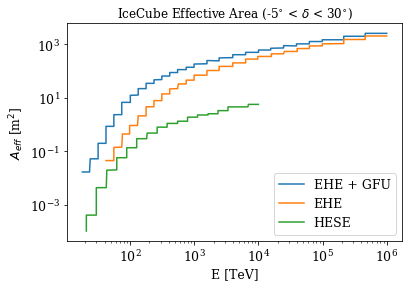

In [8]:
plt.figure(figsize=(fig_width, fig_width *2./3.))
ax = plt.subplot(111)
plt.plot(aeff_ehe_gfu["E_TeV"], aeff_ehe_gfu["A_eff"], label="EHE + GFU")
plt.plot(aeff_ehe["E_TeV"], aeff_ehe["A_eff"], label="EHE")
plt.plot(aeff_hese["E_TeV"], aeff_hese["A_eff"], label="HESE")
plt.yscale("log")
plt.xscale("log")
plt.ylabel(r"$A_{eff}$ [m$^{2}$]", fontsize=fontsize)
plt.xlabel(r"E [TeV]", fontsize=fontsize)
plt.legend(fontsize=fontsize)
ax.tick_params(axis='both', which='both', labelsize=fontsize)
plt.title(r"IceCube Effective Area (-5$^{\circ}$ < $\delta$ < 30$^{\circ}$)")

Text(0.5, 1.0, 'IceCube Effective Area (-5$^{\\circ}$ < $\\delta$ < 30$^{\\circ}$)')

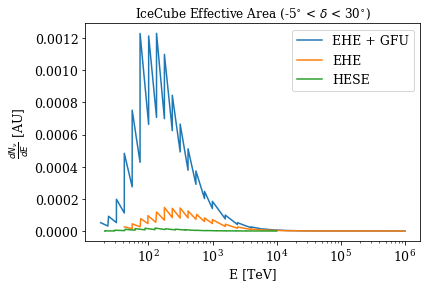

In [9]:
plt.figure(figsize=(fig_width, fig_width *2./3.))
ax = plt.subplot(111)
plt.plot(aeff_ehe_gfu["E_TeV"], aeff_ehe_gfu["A_eff"] * aeff_ehe_gfu["E_TeV"] **-2., label="EHE + GFU")
plt.plot(aeff_ehe["E_TeV"], aeff_ehe["A_eff"] * aeff_ehe["E_TeV"] **-2., label="EHE")
plt.plot(aeff_hese["E_TeV"], aeff_hese["A_eff"] * aeff_hese["E_TeV"] **-2. , label="HESE")
# plt.yscale("log")
plt.xscale("log")
plt.ylabel(r"$\frac{dN_{\nu}}{dE}$ [AU]", fontsize=fontsize)
plt.xlabel(r"E [TeV]", fontsize=fontsize)
plt.legend(fontsize=fontsize)
ax.tick_params(axis='both', which='both', labelsize=fontsize)
plt.title(r"IceCube Effective Area (-5$^{\circ}$ < $\delta$ < 30$^{\circ}$)")

In [10]:
print(np.sum(aeff_ehe_gfu["A_eff"] * aeff_ehe_gfu["E_TeV"] **-2.))

0.014623465343435827


In [11]:
def integrate_aeff(aeff_df, power=2.0, e_min_gev=x[0]/(10.**9.), e_max_gev=x[1]/(10.**9.)):
    n_iter = int(len(aeff_df["E_TeV"])/int(2))

    a_eff = 0.
    
    for i in range(n_iter):
        lower = 2*i
        upper = 2*i + 1
        e_min = aeff_df["E_TeV"][lower] * 10**3
        e_max = aeff_df["E_TeV"][upper] * 10**3
        
        if np.logical_and(e_min > e_min_gev, e_min < e_max_gev):
        
            int_factor = (1./e_min**(power - 1.) - 1./e_max**(power - 1.)) * u.GeV
            aeff = np.mean([aeff_df["A_eff"][lower], aeff_df["A_eff"][upper]]) * u.m**2
            a_eff += int_factor * aeff
    
    return a_eff

In [12]:
power = 2.0

a_eff_vals = []
norms = []

int_energy = []

for i, aeff_df in enumerate([aeff_ehe_gfu, aeff_ehe, aeff_hese]):
    
    e_min_gev = x[0]/(10. ** 9.)
    e_max_gev = x[1]/(10. ** 9.)
    
    a_eff = integrate_aeff(aeff_df, power=power, e_min_gev=e_min_gev, e_max_gev=e_max_gev)

    norm_1gev = ((1.*u.GeV)**2./a_eff/(0.5*u.year)).to("erg cm^-2 s^-1")
    norm_100tev = norm_1gev * ((100 * u.TeV).to("GeV")/ u.GeV) ** -power
        
    norms.append(norm_1gev.to("GeV cm^-2 s^-1")/(1.* u.GeV**2))
    
    a_eff_vals.append(a_eff)
    
    if power == 2.0:
        int_factor = np.log(e_max_gev/e_min_gev)
        int_energy.append(int_factor)
    else:
        int_power = 2.0 - power
        int_factor = ((e_max ** int_power) - (e_min ** int_power))/(int_power)
        raise Exception("Integrate!")
        
    print(f"A flux normalisation of {norms[i]:.2g} is required for an expectation of one neutrino alert")
    print(f"A flux of {norm_1gev:.2g} at 1 GeV is required for an expectation of one neutrino alert")

print(f"Effective area increase EHE+GFU:EHE = {(a_eff_vals[0]/a_eff_vals[1]):.2f}")
print(r"This assumes an $E^{-" + str(f"{power:.2f}") + r"}$ Power Law")


A flux normalisation of 1e-08 1 / (cm2 GeV s) is required for an expectation of one neutrino alert
A flux of 1.7e-11 erg / (cm2 s) at 1 GeV is required for an expectation of one neutrino alert
A flux normalisation of 3.3e-08 1 / (cm2 GeV s) is required for an expectation of one neutrino alert
A flux of 5.2e-11 erg / (cm2 s) at 1 GeV is required for an expectation of one neutrino alert
A flux normalisation of 0.00012 1 / (cm2 GeV s) is required for an expectation of one neutrino alert
A flux of 1.9e-07 erg / (cm2 s) at 1 GeV is required for an expectation of one neutrino alert
Effective area increase EHE+GFU:EHE = 3.17
This assumes an $E^{-2.00}$ Power Law


In [13]:
flux_t = norms[0] * (0.5*u.year).to("s")
print(f"Required time-integrated flux normalisation for one alert: {flux_t:.2g} at 1GeV")
print(f"Required fluence for one alert: {(flux_t * (int_energy[0] * u.GeV**2.)):.2g}")
fluence_erg = (flux_t * (int_energy[0] * u.GeV**2.)).to("erg cm^-2")
print(f"Required fluence for one alert: {fluence_erg:.2g}")

en = (((int_energy[0] * u.GeV**2. * flux_t)/(flux_conversion / u.cm**2)).to("erg"))
print(f"Required energy for one alert: {en:.2g}")

Required time-integrated flux normalisation for one alert: 0.16 1 / (cm2 GeV) at 1GeV
Required fluence for one alert: 0.75 GeV / cm2
Required fluence for one alert: 0.0012 erg / cm2
Required energy for one alert: 8e+51 erg


In [14]:
def expected_energy(f_a=0.1, baryon_loading=100.):
    return 7.3 * 10**48. * u.erg * f_a**(-12./19.) * baryon_loading **(11./16.)

def n_exp(f_a=0.1, baryon_loading=100.):
    return (expected_energy(f_a, baryon_loading).to("GeV")/(int_energy[0] * u.GeV**2. * flux_t.to("GeV^-1 cm^-2")/(flux_conversion / u.cm**2) )).to("")

In [15]:
n_exp(baryon_loading=100.)

<Quantity 0.09297716>

In [16]:
def target_photons(e_nu, gamma=1.):
    e_p = 20. * e_nu.to("GeV")
    
    # For delta resonance:
    # E gamma E_p = gamma^2 0.5 GeV^2
    e_gamma = (gamma ** 2. * (0.5 * u.GeV ** 2.) / e_p).to("eV")
    
    # Planck's law
    nu = (e_gamma / const.h).to("Hz")
    wl = (const.c / nu).to("nm")
    
    print(f"Photon Energy is {e_gamma:.2g}")
    print(f"This corresponds to a frequency of {nu:.2g}, or a wavelength of {wl:.2g}")
    
    return e_gamma

In [17]:
target_photons(0.2 * u.PeV)

Photon Energy is 1.2e+02 eV
This corresponds to a frequency of 3e+16 Hz, or a wavelength of 9.9 nm


<Quantity 125. eV>

In [18]:
wiens_law(10**4.6 * u.K)

<Quantity 72.78874056 nm>

In [19]:
def monoenergetic_threshold(e_nu):
    e_nu_tev = e_nu.to("TeV")
    bin_mask = aeff_ehe_gfu["E_TeV"] > e_nu_tev
    aeff = aeff_ehe_gfu[bin_mask].iloc[1]["A_eff"] * u.m**2
    number_flux = (1./aeff).to("cm^-2")
    fluence = number_flux * e_nu_tev.to("erg")
    print(fluence / (flux_conversion/ u.cm**2 ))
    return fluence

In [20]:
monoenergetic_threshold(1*u.PeV)

4.291117367311467e+51 cm2 erg / cm2


<Quantity 0.00064754 erg / cm2>

4.517642540094307e+51 cm2 erg / cm2
4.7392286106294637e+51 cm2 erg / cm2
4.96081468116462e+51 cm2 erg / cm2
5.182400751699777e+51 cm2 erg / cm2
3.896168928526867e+51 cm2 erg / cm2
4.055928156558513e+51 cm2 erg / cm2
4.2156873845901586e+51 cm2 erg / cm2
4.3754466126218035e+51 cm2 erg / cm2
4.53520584065345e+51 cm2 erg / cm2
4.694965068685096e+51 cm2 erg / cm2
4.8547242967167406e+51 cm2 erg / cm2
5.014483524748386e+51 cm2 erg / cm2
3.825597359975923e+51 cm2 erg / cm2
3.943715993018658e+51 cm2 erg / cm2
4.061834626061393e+51 cm2 erg / cm2
4.179953259104127e+51 cm2 erg / cm2
4.298071892146862e+51 cm2 erg / cm2
4.4161905251895975e+51 cm2 erg / cm2
4.534309158232331e+51 cm2 erg / cm2
4.652427791275067e+51 cm2 erg / cm2
4.770546424317802e+51 cm2 erg / cm2
4.888665057360537e+51 cm2 erg / cm2
3.892863818646736e+51 cm2 erg / cm2
3.984703167281156e+51 cm2 erg / cm2
4.076542515915576e+51 cm2 erg / cm2
4.168381864549996e+51 cm2 erg / cm2
4.260221213184416e+51 cm2 erg / cm2
4.352060561818836e+51 cm2

6.422735338703761e+51 cm2 erg / cm2
6.448183226760403e+51 cm2 erg / cm2
6.473631114817043e+51 cm2 erg / cm2
6.499079002873685e+51 cm2 erg / cm2
6.524526890930326e+51 cm2 erg / cm2
6.549974778986967e+51 cm2 erg / cm2
6.57542266704361e+51 cm2 erg / cm2
6.600870555100251e+51 cm2 erg / cm2
6.626318443156891e+51 cm2 erg / cm2
6.651766331213533e+51 cm2 erg / cm2
6.677214219270175e+51 cm2 erg / cm2
6.702662107326816e+51 cm2 erg / cm2
6.728109995383458e+51 cm2 erg / cm2
6.7535578834401e+51 cm2 erg / cm2
6.779005771496741e+51 cm2 erg / cm2
6.804453659553383e+51 cm2 erg / cm2
6.829901547610022e+51 cm2 erg / cm2
6.855349435666663e+51 cm2 erg / cm2
6.880797323723307e+51 cm2 erg / cm2
6.906245211779948e+51 cm2 erg / cm2
6.93169309983659e+51 cm2 erg / cm2
6.957140987893231e+51 cm2 erg / cm2
6.982588875949871e+51 cm2 erg / cm2
7.008036764006513e+51 cm2 erg / cm2
7.033484652063155e+51 cm2 erg / cm2
7.058932540119796e+51 cm2 erg / cm2
7.084380428176438e+51 cm2 erg / cm2
7.109828316233077e+51 cm2 erg / 

1.0141324179156284e+52 cm2 erg / cm2
1.0162131686265349e+52 cm2 erg / cm2
1.0182939193374411e+52 cm2 erg / cm2
1.0203746700483478e+52 cm2 erg / cm2
1.0224554207592539e+52 cm2 erg / cm2
1.0245361714701603e+52 cm2 erg / cm2
1.0266169221810668e+52 cm2 erg / cm2
1.0286976728919731e+52 cm2 erg / cm2
1.0307784236028794e+52 cm2 erg / cm2
1.0328591743137859e+52 cm2 erg / cm2
1.0349399250246922e+52 cm2 erg / cm2
1.0370206757355986e+52 cm2 erg / cm2
1.039101426446505e+52 cm2 erg / cm2
1.0411821771574113e+52 cm2 erg / cm2
1.0432629278683177e+52 cm2 erg / cm2
1.045343678579224e+52 cm2 erg / cm2
1.0474244292901304e+52 cm2 erg / cm2
1.0495051800010368e+52 cm2 erg / cm2
1.051585930711943e+52 cm2 erg / cm2
1.0536666814228494e+52 cm2 erg / cm2
1.0557474321337559e+52 cm2 erg / cm2
1.0578281828446622e+52 cm2 erg / cm2
1.0599089335555685e+52 cm2 erg / cm2
1.0619896842664747e+52 cm2 erg / cm2
1.0640704349773814e+52 cm2 erg / cm2
1.0661511856882878e+52 cm2 erg / cm2
1.0682319363991938e+52 cm2 erg / cm2
1.07

1.2443313494588537e+52 cm2 erg / cm2
1.2460326786659378e+52 cm2 erg / cm2
1.247734007873022e+52 cm2 erg / cm2
1.249435337080106e+52 cm2 erg / cm2
1.2511366662871904e+52 cm2 erg / cm2
1.2528379954942747e+52 cm2 erg / cm2
1.254539324701359e+52 cm2 erg / cm2
1.2562406539084433e+52 cm2 erg / cm2
1.2579419831155274e+52 cm2 erg / cm2
1.2596433123226117e+52 cm2 erg / cm2
1.2613446415296955e+52 cm2 erg / cm2
1.26304597073678e+52 cm2 erg / cm2
1.2647472999438643e+52 cm2 erg / cm2
1.2664486291509486e+52 cm2 erg / cm2
1.2681499583580324e+52 cm2 erg / cm2
1.2698512875651167e+52 cm2 erg / cm2
1.271552616772201e+52 cm2 erg / cm2
1.2732539459792853e+52 cm2 erg / cm2
1.2749552751863694e+52 cm2 erg / cm2
1.2766566043934534e+52 cm2 erg / cm2
1.2783579336005377e+52 cm2 erg / cm2
1.280059262807622e+52 cm2 erg / cm2
1.2817605920147063e+52 cm2 erg / cm2
1.2834619212217904e+52 cm2 erg / cm2
1.2851632504288747e+52 cm2 erg / cm2
1.2868645796359587e+52 cm2 erg / cm2
1.288565908843043e+52 cm2 erg / cm2
1.2902672

1.6815729556794947e+52 cm2 erg / cm2
1.6832742848865792e+52 cm2 erg / cm2
1.6849756140936633e+52 cm2 erg / cm2
1.6866769433007476e+52 cm2 erg / cm2
1.688378272507832e+52 cm2 erg / cm2
1.6900796017149162e+52 cm2 erg / cm2
1.6917809309220002e+52 cm2 erg / cm2
1.6934822601290843e+52 cm2 erg / cm2
1.6951835893361688e+52 cm2 erg / cm2
1.6968849185432523e+52 cm2 erg / cm2
1.698586247750337e+52 cm2 erg / cm2
1.7002875769574212e+52 cm2 erg / cm2
1.7019889061645055e+52 cm2 erg / cm2
1.7036902353715893e+52 cm2 erg / cm2
1.7053915645786739e+52 cm2 erg / cm2
1.707092893785758e+52 cm2 erg / cm2
1.7087942229928422e+52 cm2 erg / cm2
1.7104955521999265e+52 cm2 erg / cm2
1.7121968814070106e+52 cm2 erg / cm2
1.713898210614095e+52 cm2 erg / cm2
1.715599539821179e+52 cm2 erg / cm2
1.7173008690282632e+52 cm2 erg / cm2
1.7190021982353475e+52 cm2 erg / cm2
1.7207035274424315e+52 cm2 erg / cm2
1.7224048566495159e+52 cm2 erg / cm2
1.7241061858566002e+52 cm2 erg / cm2
1.7258075150636842e+52 cm2 erg / cm2
1.7275

Text(0.5, 0, '$E_{\\nu}$ [TeV]')

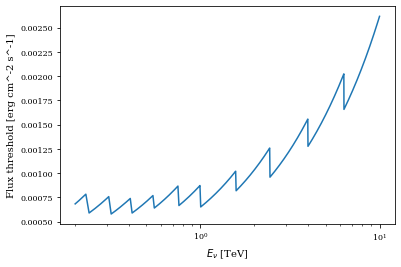

In [21]:
x = np.linspace(0.2, 10, 1000)
plt.plot(x, [monoenergetic_threshold(a*u.PeV).value for a in x])
plt.xscale("log")
plt.ylabel(r"Flux threshold [erg cm^-2 s^-1]")
plt.xlabel(r"$E_{\nu}$ [TeV]")

In [22]:
from scipy.stats import poisson
n_trials = 9.

In [23]:
def trial_correct(n_years, confidence=0.95):
    return confidence**(1./(n_years*n_trials))

In [24]:
thresh = trial_correct(7.)
print(thresh)

0.9991861520780205


In [25]:
poisson.cdf(1, mu=0.04)

0.9992210167184161

# Needed: Mathematical proof that this represents the most conservative distribution, i.e the one least likely to give a neutrino multiplet

In [85]:
cs = 5 * 10 ** -28 * u.cm**2
rbb = 10**14.5 * u.cm

def optical_depth(nu_hz, tk):
    
    nu = nu_hz * u.Hz
    t = tk * u.Kelvin
    
    e_photon = (const.h * nu)
    
    frac = e_photon/(const.k_B * t)
    
    dnu = nu
    
    # photon number density is mathematically equivalent to spectral energy density?
    
    sed = ((8 * np.pi * const.h * nu**3) * (1./(np.exp(frac) - 1.))/(const.c**3)).to("eV Hz^-1 cm^-3")
    print(f"Spectral Energy Density: {sed:.2g}")
    
    
    number_density = 0.1*nu * sed/e_photon.to("eV")
    
    print(f"Number Density: {number_density:.2g}")
    
    mfp = (1./(cs * number_density)).to("cm")
    
    print(f"Mean Free Path: {mfp:.2g}")
    
    return 1-np.exp(-rbb/mfp/5.)

optical_depth(10**15, 10**4.6)

Spectral Energy Density: 1.6 eV / (cm3 Hz)
Number Density: 4e+13 1 / cm3
Mean Free Path: 5e+13 cm


<Quantity 0.71673576>